In [144]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import os
import warnings
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from sklearn import metrics
warnings.filterwarnings("ignore")
plt.style.use('ggplot')

In [145]:
data = pd.read_csv("Gosan_Flask_CO2_del13C_2001-2011 -.csv")

In [146]:
data["Time"] = pd.to_datetime(data["Time"])

In [147]:
data

,Time,13C [permil],CO2
0,2001-01-03 12:44:00,-8.310,376.06
1,2001-01-10 12:52:00,-8.230,374.52
2,2001-01-10 12:53:00,-8.240,374.49
3,2001-01-17 12:47:00,-8.380,377.49
4,2001-01-17 12:48:00,-8.380,377.37
...,...,...,...
414,2011-10-27 12:36:00,-8.809,402.95
415,2011-11-29 12:56:00,-8.669,401.82
416,2012-01-12 12:01:00,-8.500,396.51
417,2012-01-19 13:19:00,-9.048,410.01


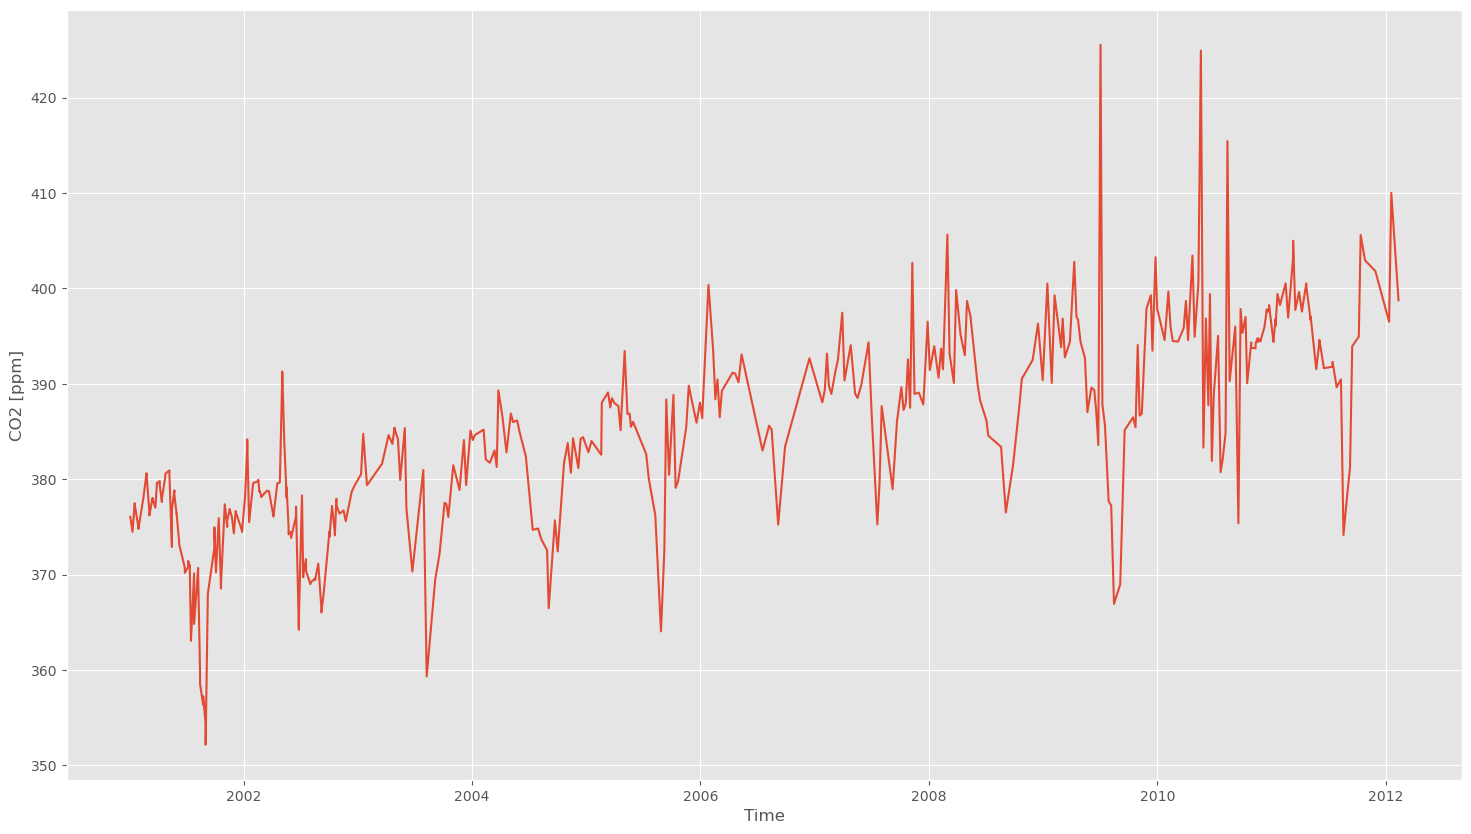

In [148]:
plt.figure(figsize=(18,10))
plt.plot(data["Time"], data["CO2"])
plt.xlabel("Time")
plt.ylabel("CO2 [ppm]")
plt.show()

<Figure size 640x480 with 0 Axes>

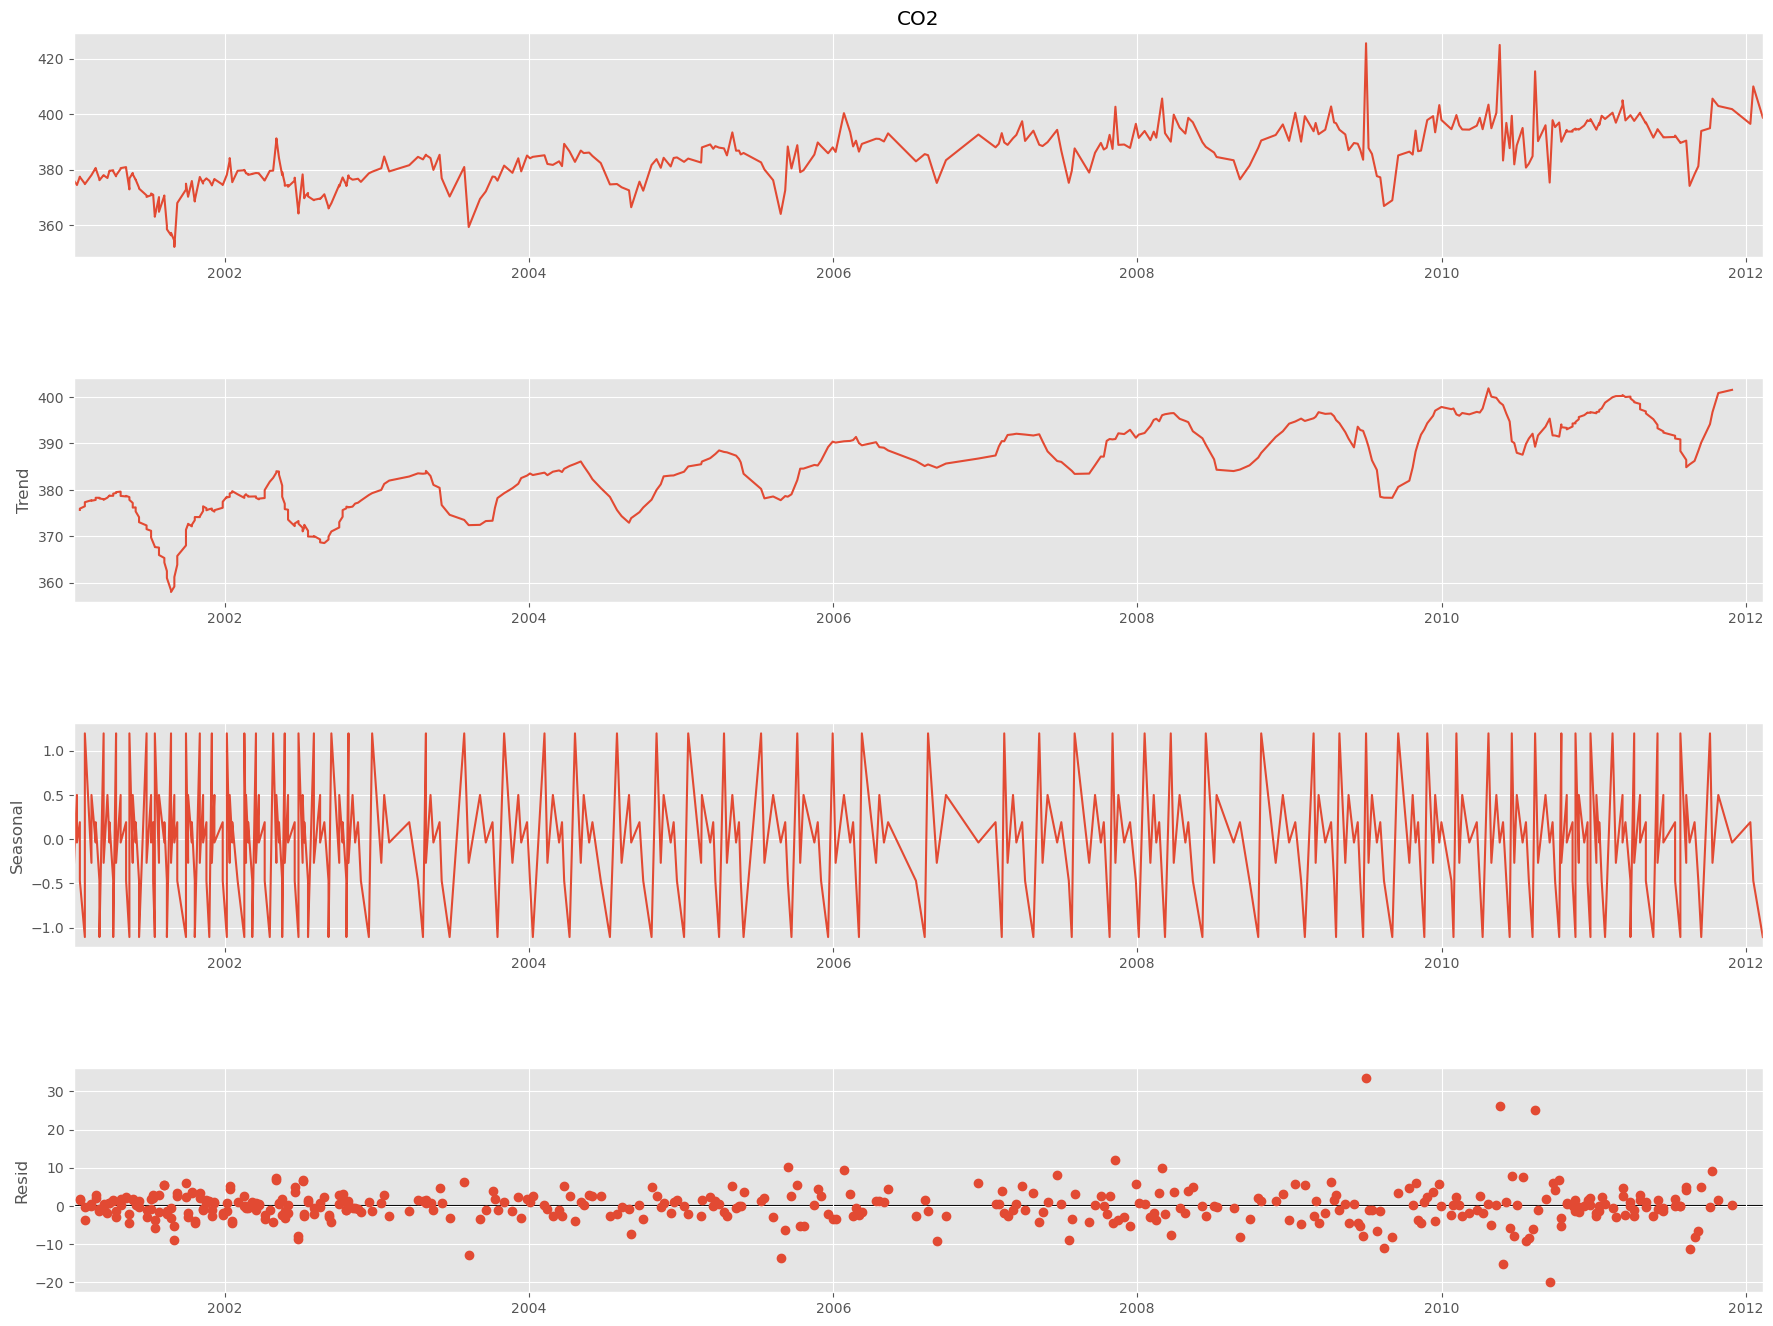

In [149]:
timeSeries = data[["Time", "CO2"]]
timeSeries.index = timeSeries.Time
ts = timeSeries.drop("Time", axis=1)
result = seasonal_decompose(ts["CO2"], model="additive", period=7)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(20, 15)

In [150]:
ts

,CO2
Time,
2001-01-03 12:44:00,376.06
2001-01-10 12:52:00,374.52
2001-01-10 12:53:00,374.49
2001-01-17 12:47:00,377.49
2001-01-17 12:48:00,377.37
...,...
2011-10-27 12:36:00,402.95
2011-11-29 12:56:00,401.82
2012-01-12 12:01:00,396.51


In [151]:
result = adfuller(ts)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.458976
p-value: 0.125777
Critical Values:
	1%: -3.446
	5%: -2.869
	10%: -2.571


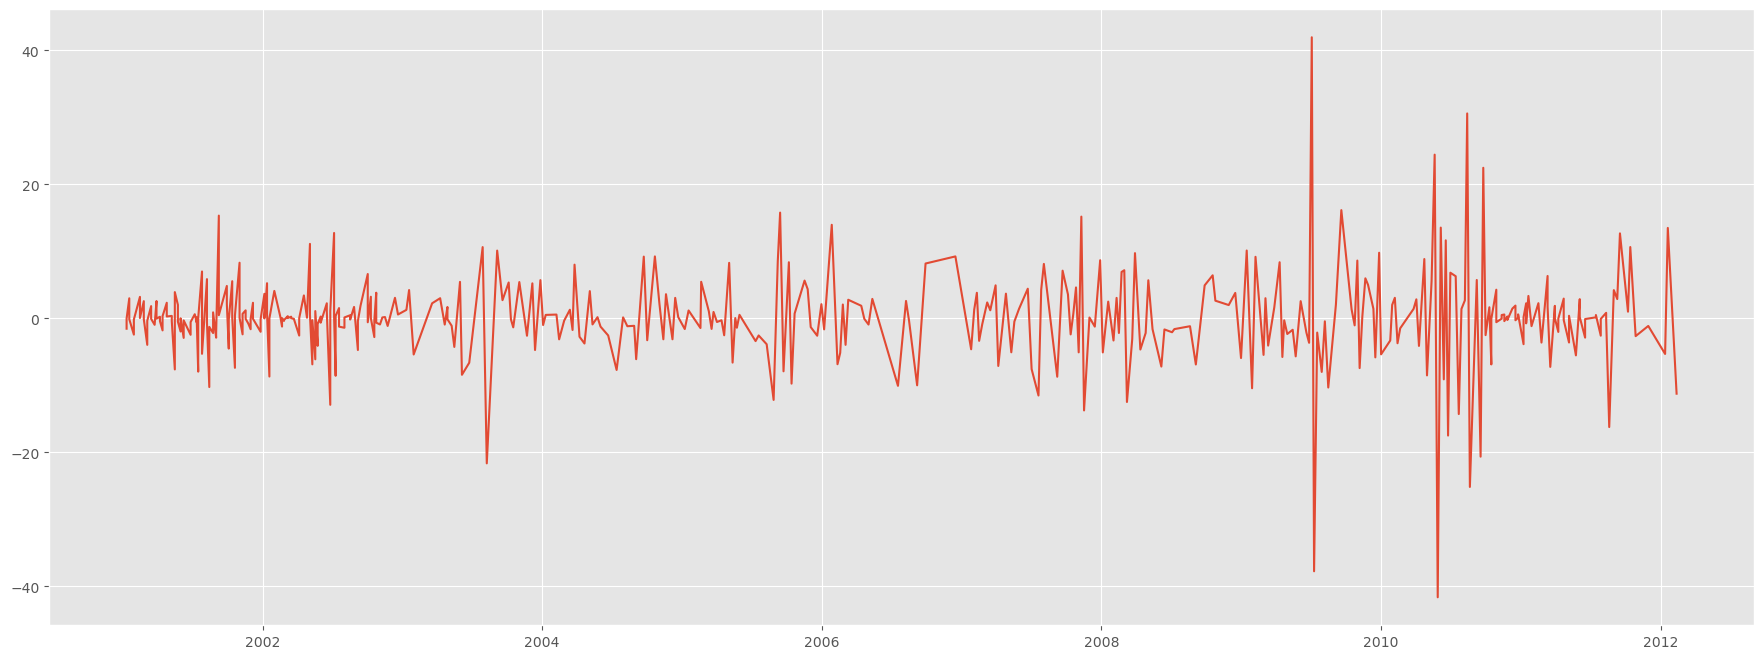

In [152]:
ts_diff = ts - ts.shift()
plt.figure(figsize=(22,8))
plt.plot(ts_diff)
plt.show()

In [153]:
result = adfuller(ts_diff[1:])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -11.614394
p-value: 0.000000
Critical Values:
	1%: -3.446
	5%: -2.869
	10%: -2.571


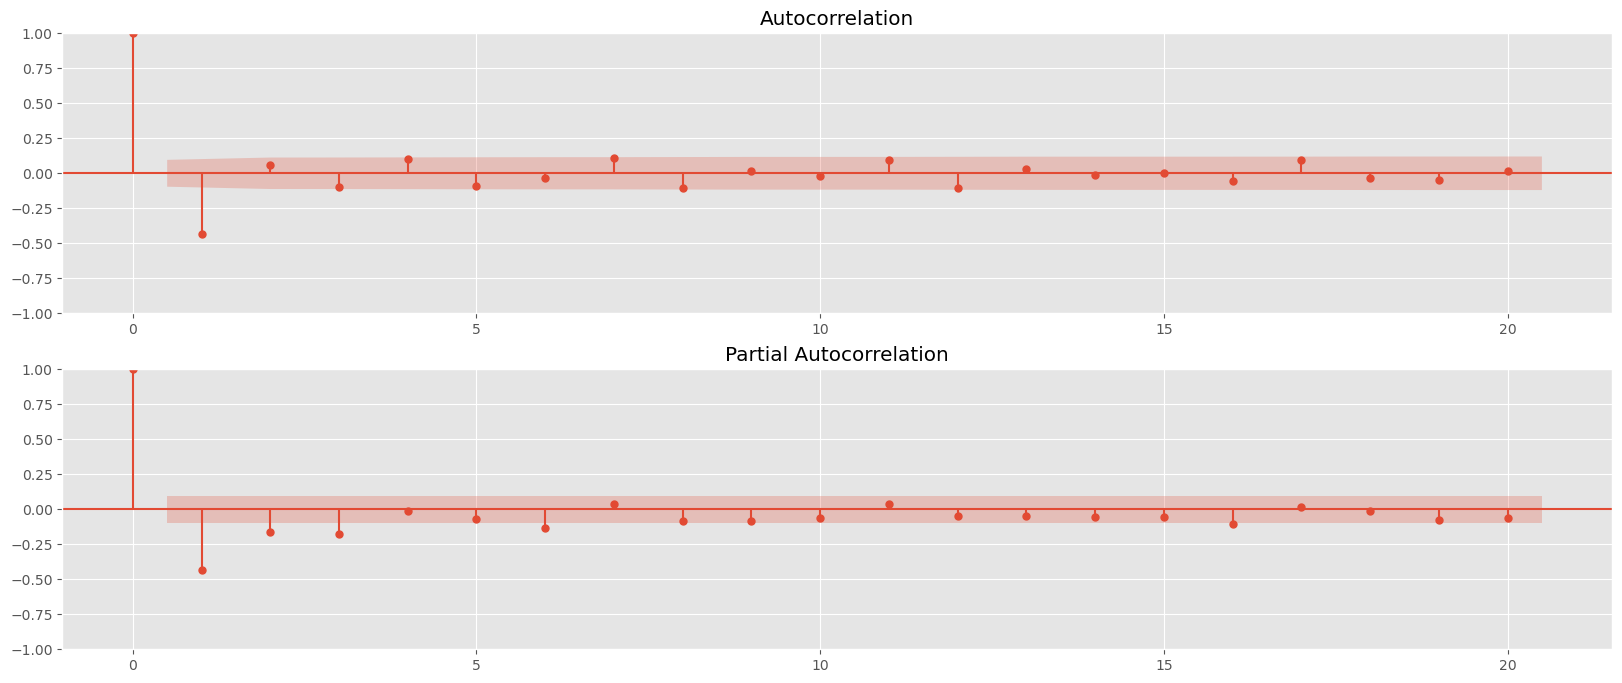

In [154]:
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts_diff[1:], lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts_diff[1:], lags=20, ax=ax2)

In [155]:
train_start_index = 0
train_end_index = 365  # 1년치 데이터로 학습 예시
train_data = data[train_start_index:train_end_index]

In [156]:
prediction_start_index = train_end_index
prediction_end_index = prediction_start_index + 365  # 1년치 데이터를 예측 예시
prediction_data = data[prediction_start_index:prediction_end_index]

In [157]:
model = ARIMA(train_data["CO2"], order=(2, 1, 2))
model_fit = model.fit()

In [158]:
predictions = []

In [159]:
predictions.extend(model_fit.predict(start=prediction_start_index, end=prediction_end_index-1, typ='levels'))

In [160]:
next_prediction_start_index = prediction_end_index
next_prediction_end_index = next_prediction_start_index + 365  # 1년치 데이터를 예측 예시

In [161]:
while next_prediction_end_index <= len(data):
    next_prediction_data = data[next_prediction_start_index:next_prediction_end_index]
    updated_data = pd.concat([train_data, prediction_data])
    
    # 모델 재학습
    model_fit = ARIMA(updated_data["CO2"], order=(2, 1, 2))
    model_fit = model.fit()
    
    # 다음 예측 결과 저장
    predictions.extend(model_fit.predict(start=next_prediction_start_index, end=next_prediction_end_index-1, typ='levels'))
    
    # 다음 예측 대상 설정
    prediction_start_index = next_prediction_start_index
    prediction_end_index = next_prediction_end_index
    prediction_data = data[prediction_start_index:prediction_end_index]
    
    # 다음 예측 대상 범위 업데이트
    next_prediction_start_index = prediction_end_index
    next_prediction_end_index = next_prediction_start_index + 365

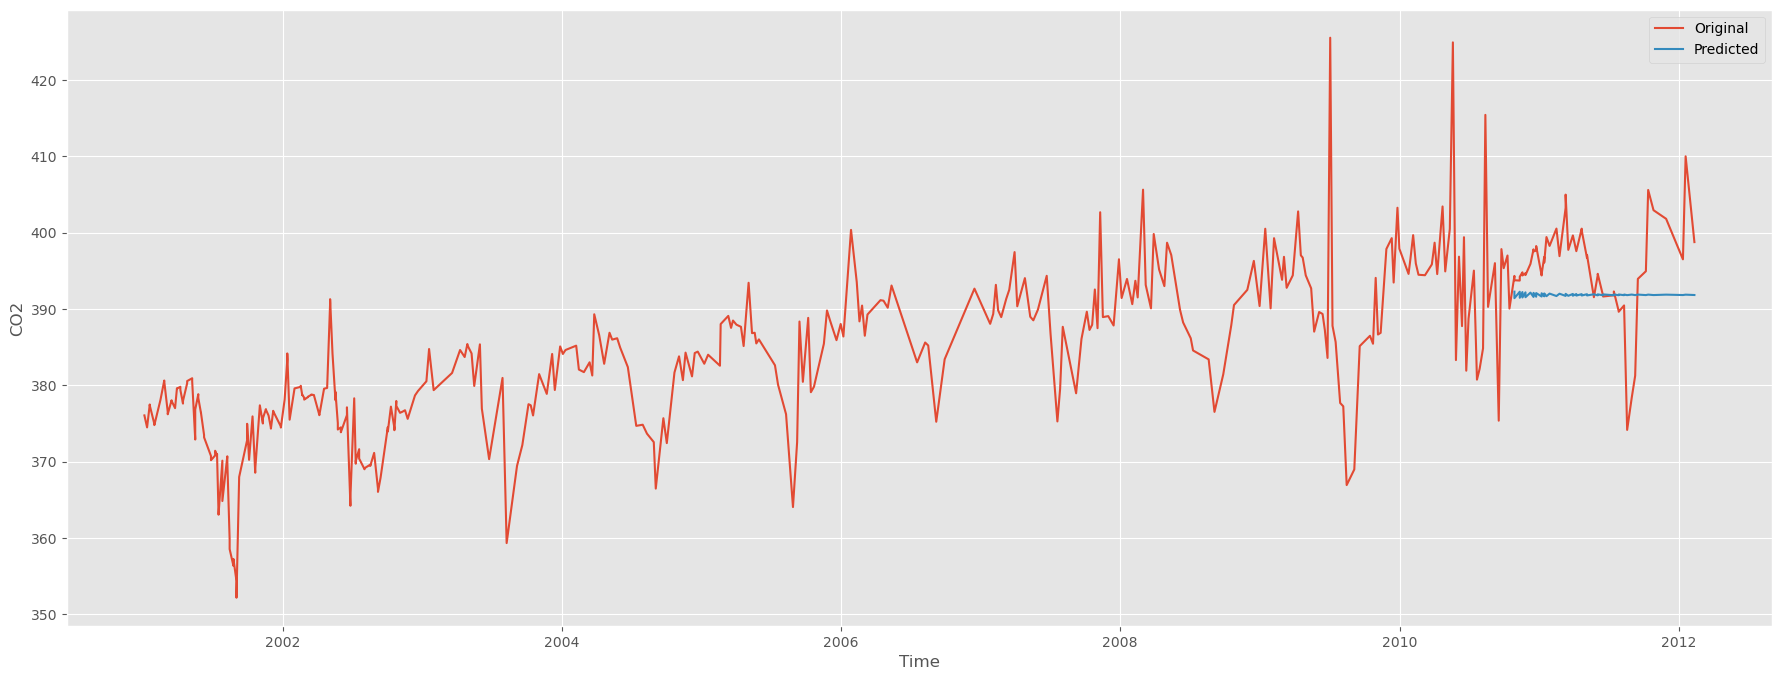

In [163]:
plt.figure(figsize=(22, 8))
plt.plot(data["Time"], data["CO2"], label="Original")
plt.plot(data["Time"][prediction_start_index:prediction_end_index], predictions[:len(data["Time"][prediction_start_index:prediction_end_index])], label="Predicted")
plt.xlabel("Time")
plt.ylabel("CO2")
plt.legend()
plt.show()


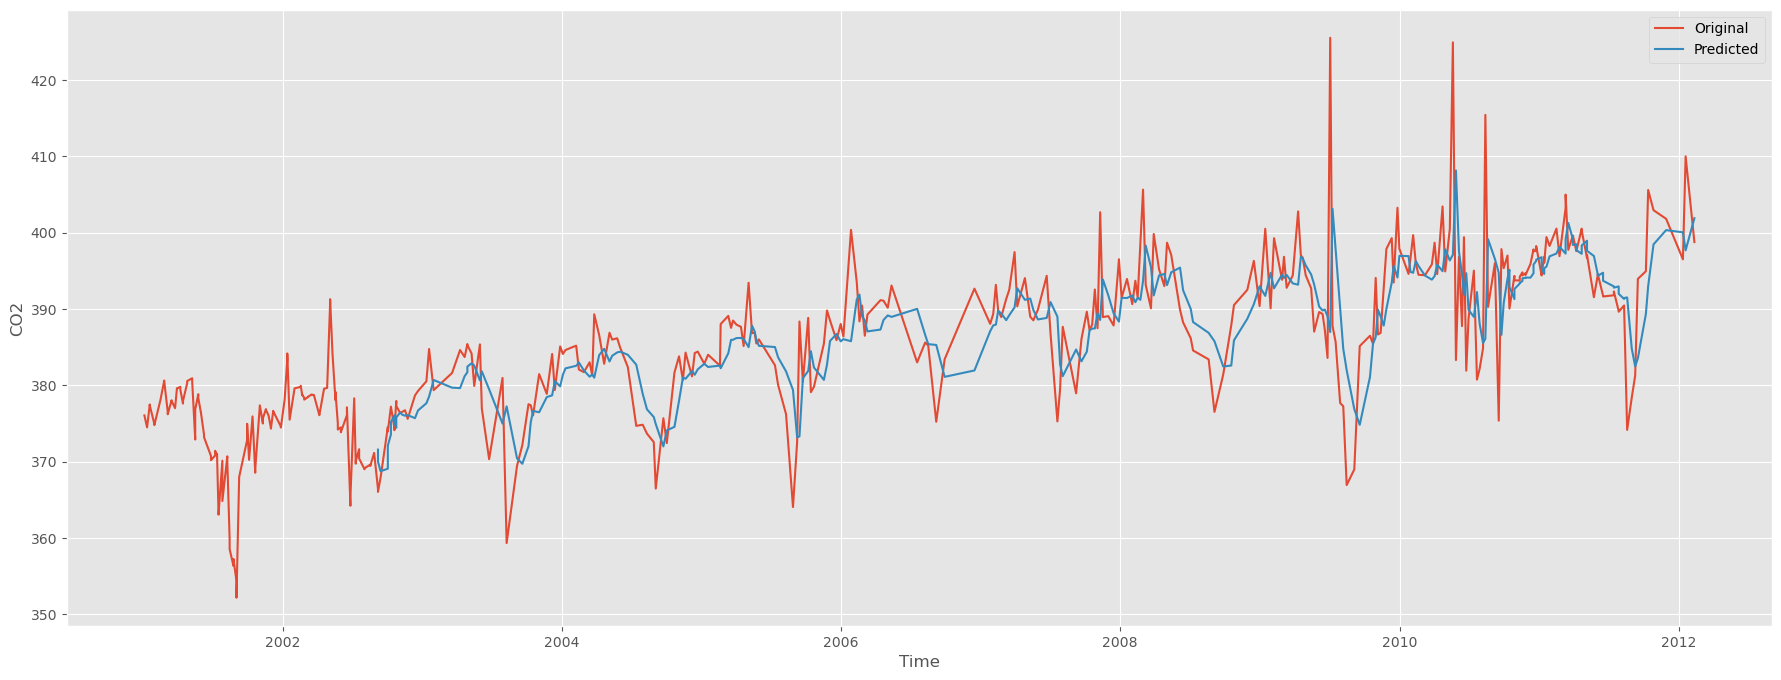

In [66]:
plt.figure(figsize=(22,8))
plt.plot(data["Time"], data["CO2"], label="Original")
plt.plot(data.Time[data.Time >= start_index], forecast, label="Predicted")
plt.xlabel("Time")
plt.ylabel("CO2")
plt.legend()
plt.show()


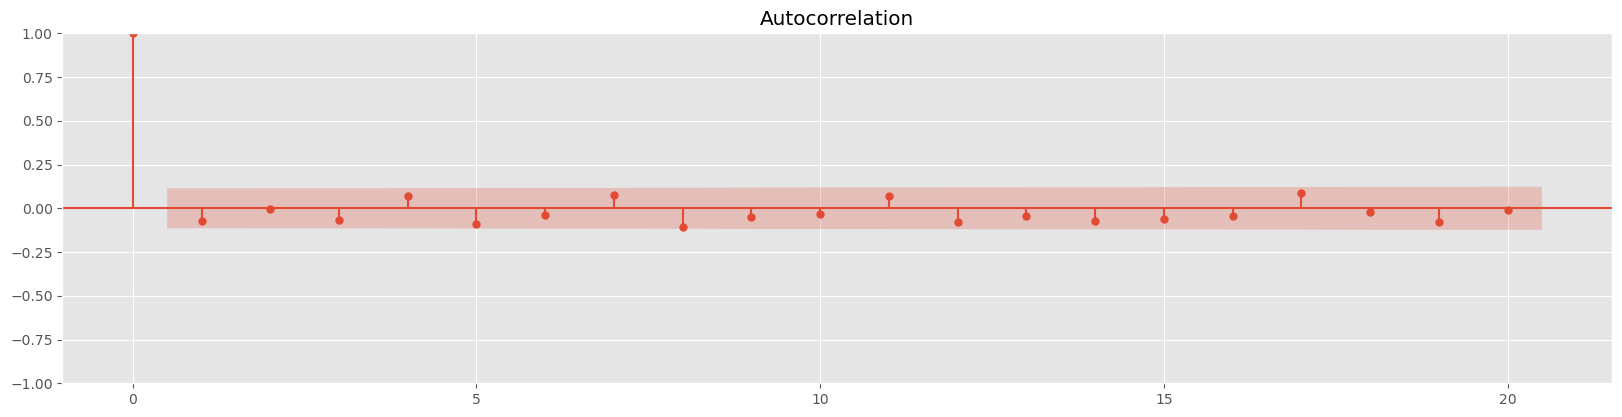

In [67]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resi, lags=20, ax=ax1)

In [68]:
result = adfuller(resi)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -18.376512
p-value: 0.000000
Critical Values:
	1%: -3.453
	5%: -2.871
	10%: -2.572


In [69]:
from sklearn import metrics

In [72]:
def scoring(y_true, y_pred):
    r2 = round(metrics.r2_score(y_true, y_pred) * 100, 3)
    corr = round(np.corrcoef(y_true, y_pred)[0,1],3)
    mape = round(
        metrics.mean_absolute_percentage_error(y_true, y_pred) * 100, 3)
    rmse = round(metrics.mean_squared_error(y_true, y_pred, squared=False),3)
    
    df = pd.DataFrame({
        'R2': r2,
        'Corr': corr,
        'PMSE': rmse,
        'MAPE': mape
    },
        index=[0])
    return df

In [74]:
# R2 : 결정 계수, Corr : 상관 계수, PMSE : 평균 제곱근 오차, MAPE : 평균 절대 백분율 오차
scoring(np.array(data[data["Time"] >= start_index]["CO2"]), np.array(forecast))

,R2,Corr,PMSE,MAPE
0,53.04,0.736,6.329,1.072
